In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

- 요약: OpenMP (Open Multi-Processing) 라이브러리가 사용할 스레드의 개수를 1개로 제한하는 역할  
    즉, 라이브러리 내부에서 잠재적으로 발생할 수 있는 병렬 연산을 명시적으로 끄고 싱글 스레드 실행을 강제하는 명령

🛠️ 역할 및 배경

1. OpenMP (OMP)

    OpenMP는 주로 C, C++, 포트란 등에서 사용되는 공유 메모리 병렬 프로그래밍 API  
    행렬 연산이나 수치 계산 라이브러리(예: NumPy, SciPy, scikit-learn의 일부 백엔드 등)에서  
    성능 향상을 위해 내부적으로 OpenMP를 사용하여 작업을 여러 스레드로 분산하여 처리하는 경우가 많음

2. 환경 변수 OMP_NUM_THREADS

    이 환경 변수는 OpenMP 런타임이 병렬 영역을 실행할 때 기본적으로 사용할 스레드의 개수를 지정

3. "1"로 설정하는 이유

    값을 "1"로 설정하면, 병렬 처리가 필요한 경우에도 OpenMP는 단 하나의 스레드만 사용하여 코드를 실행하게 됨  
    즉, 병렬 처리를 비활성화하거나 직렬 처리를 강제하는 효과가 있음

이 설정은 다음과 같은 상황에서 유용: 

- 디버깅: 병렬 실행 시 발생할 수 있는 복잡한 오류(경쟁 상태 등)를 배제하고 직렬 실행을 확인하여 디버깅을 단순화

- 중첩 병렬화 제어: 여러 프로세스나 라이브러리가 이미 자체적으로 병렬 처리를 수행하고 있을 때  
 (예: 멀티프로세싱 + OpenMP), 성능 저하(오버헤드)나 리소스 충돌을 방지하기 위해 OpenMP의 병렬화를 제한

- 일관된 성능 측정: 특정 코드나 라이브러리의 직렬 성능을 정확하게 측정하고자 할 때 사용

In [2]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# k-means clustering

### 데이터 준비


In [3]:
# --------------------
# 클러스터링(Clustering) 실습에 사용할 가상의 데이터 생성
# --------------------

from sklearn.datasets import make_blobs
features, targets, centers_coords = make_blobs(n_samples=200, 
                                               n_features=2,
                                               centers=3,
                                               cluster_std=0.8,
                                               random_state=0,
                                               return_centers=True)

df = pd.DataFrame(features, columns=['feature1','feature2'])
df

,feature1,feature2
0,-1.692427,3.622025
1,0.697940,4.428867
2,1.100228,4.606317
3,-1.448724,3.384245
4,1.214861,5.364896
...,...,...
195,2.956576,0.033718
196,-2.074113,4.245523
197,2.783411,1.151438
198,1.226724,3.620511


- make_blobs: 지정된 수의 클러스터를 가진 등방성 가우시안 덩어리(isotropic Gaussian blobs) 데이터를 생성
- n_samples=200: 생성할 데이터의 총 샘플(행) 개수를 200개로 지정
- n_features=2: 각 샘플이 가질 피처(열, 특성)의 개수를 2개로 지정
- centers=3: 데이터가 생성될 클러스터(중심점)의 개수를 3개로 지정
- random_state=0: 난수 발생 시드(seed)를 0으로 고정 (실행 시 항상 같은 데이터 생성)
- centers_coords: (3, 2) 형태의 Numpy 배열로 make_blobs로 생성된 클러스터의 실제 중심 좌표

&nbsp;&nbsp;&nbsp;결과
- features: 200행 $\times$ 2열 형태의 데이터 포인트(피처) 배열이 저장  
    즉, 총 200개의 데이터 포인트를 3개의 중심 주변에 분배

- targets: 각 데이터 포인트가 속한 클러스터 번호(타겟 레이블) 배열이 저장

    make_blobs 함수는 학습용 가상 데이터를 만들 때, 단순히 데이터 포인트(features)만 만드는 것이 아니라,  
    각 데이터 포인트가 어느 그룹에 속해야 하는지에 대한 정보도 함께 만들며 이 정보가 바로 targets 배열에 저장

    targets 배열은 features 배열과 **같은 길이(200개)**를 가지며,  
    targets의 첫 번째 값은 features의 첫 번째 행(데이터 포인트)이 속한 그룹의 번호

    즉, centers=3으로 설정했기 때문에, targets 배열에는 0, 1, 2 세 가지 숫자(클러스터 번호)만 포함  
    - 0: 첫 번째 가상 중심점 주변에 뿌려진 데이터 포인트.

    - 1: 두 번째 가상 중심점 주변에 뿌려진 데이터 포인트.

    - 2: 세 번째 가상 중심점 주변에 뿌려진 데이터 포인트.

In [4]:
# --------------------
# targets 데이터프레임 생성
# --------------------
targets = pd.DataFrame(targets)
targets.columns = ['targets']
targets

,targets
0,2
1,0
2,0
3,2
4,0
...,...
195,1
196,2
197,1
198,0


In [5]:
# --------------------
# targets 데이터 빈도수
# --------------------
targets.value_counts()

targets
0          67
1          67
2          66
Name: count, dtype: int64

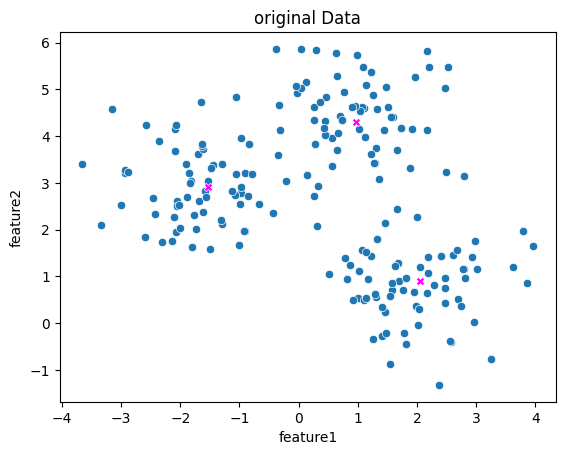

In [6]:
# --------------------
# 데이터 시각화
# --------------------
sns.scatterplot( x='feature1', y='feature2', data=df)

# --------------------
# 개별 군집의 중심 좌표
# --------------------
sns.scatterplot(x=centers_coords[:,0], 
                y=centers_coords[:,1], 
                color='magenta',
                marker='X')

plt.title('original Data');

In [7]:
# --------------------
# make_blobs로 생성된 데이터의 '실제' 중심 좌표
# --------------------
print(centers_coords)

[[ 0.97627008  4.30378733]
 [ 2.05526752  0.89766366]
 [-1.52690401  2.91788226]]


### 전처리

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)
X_scaled = pd.DataFrame(X_scaled, columns=df.columns)
X_scaled

,feature1,feature2
0,-1.226105,0.541123
1,0.155288,1.019338
2,0.387771,1.124513
3,-1.085269,0.400190
4,0.454017,1.574123
...,...,...
195,1.460554,-1.585668
196,-1.446681,0.910670
197,1.360482,-0.923195
198,0.460873,0.540225


### 군집화

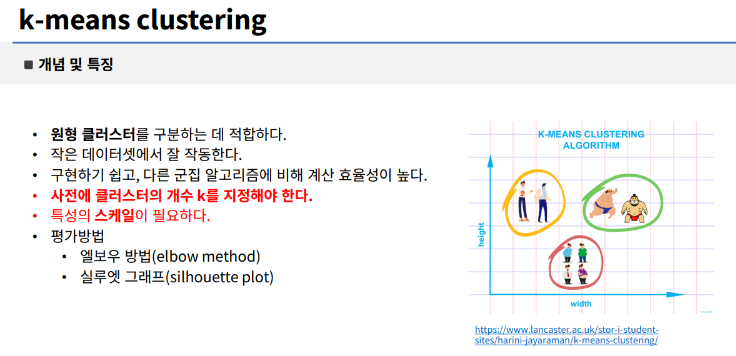

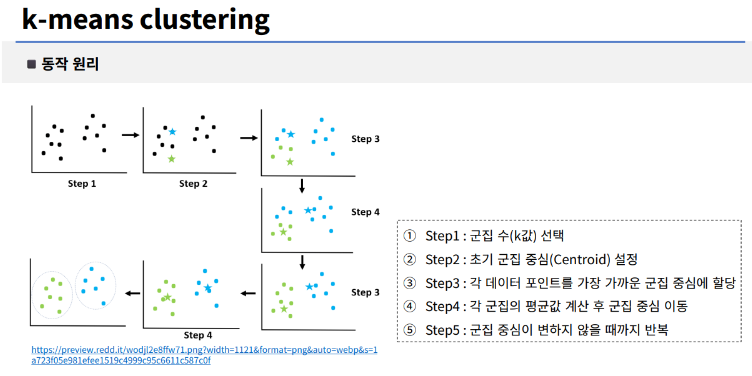

In [9]:
# --------------------
# 클러스터링 모델 객체 생성
# --------------------
from sklearn.cluster import KMeans
km= KMeans(n_clusters=3, random_state=42)

# --------------------
# 학습 
# --------------------
km.fit(X_scaled)

,n_clusters,3
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


## 클러스터링 결과
- 개별 데이터의 군집 결과 : `모델.labels_`
- 클러스터의 중심 : `모델.cluster_centers_`
- 이너셔 : `모델.inertia_`

In [10]:
# --------------------
# 개별 데이터의 군집 label (클러스터 레이블)
# --------------------
cluster = km.labels_
cluster

array([2, 0, 0, 2, 0, 2, 1, 1, 0, 2, 0, 2, 0, 0, 0, 2, 1, 1, 0, 2, 2, 1,
       0, 0, 2, 0, 1, 2, 2, 2, 0, 0, 2, 0, 1, 1, 0, 1, 1, 2, 1, 2, 2, 2,
       0, 0, 0, 2, 0, 0, 0, 1, 2, 2, 2, 2, 1, 1, 0, 0, 2, 2, 0, 1, 1, 2,
       1, 1, 2, 1, 1, 0, 0, 2, 0, 2, 1, 1, 1, 2, 2, 0, 0, 1, 1, 0, 0, 2,
       0, 1, 2, 2, 1, 0, 1, 0, 0, 2, 2, 1, 1, 0, 2, 0, 2, 0, 1, 0, 0, 1,
       0, 2, 1, 2, 0, 0, 0, 1, 2, 2, 1, 1, 2, 0, 1, 0, 2, 1, 2, 0, 2, 1,
       1, 1, 0, 1, 1, 0, 1, 2, 2, 2, 0, 1, 1, 0, 2, 2, 1, 0, 1, 2, 2, 2,
       0, 1, 1, 1, 0, 0, 1, 2, 2, 2, 0, 0, 1, 2, 1, 1, 0, 1, 0, 1, 2, 2,
       0, 2, 0, 1, 0, 2, 1, 1, 1, 0, 2, 1, 0, 0, 2, 2, 1, 1, 1, 1, 2, 1,
       0, 1], dtype=int32)

KMeans는 비지도 학습(Unsupervised Learning) 알고리즘 모델을 학습할 때,  
targets을 사용하지 않고 오직 features (데이터의 특징)만을 기반으로 데이터를 비슷한 그룹으로 스스로 묶었음

이때, 모델이 데이터를 군집화한 결과로, 각 군집에 임의로 부여한 레이블(0, 1, 2)

In [11]:
# 원본 레이블의 targets (미리 정해둔 정답)
targets_array = targets['targets'].values
targets_array

array([2, 0, 0, 2, 0, 2, 1, 1, 0, 2, 0, 2, 0, 0, 0, 2, 1, 1, 0, 2, 2, 1,
       0, 0, 2, 0, 1, 2, 2, 2, 0, 0, 2, 0, 1, 1, 0, 1, 1, 2, 1, 2, 2, 2,
       0, 0, 0, 2, 0, 0, 0, 1, 2, 2, 2, 2, 1, 1, 0, 0, 2, 2, 0, 1, 1, 2,
       1, 1, 2, 1, 1, 0, 0, 2, 0, 2, 1, 1, 1, 2, 2, 0, 0, 1, 1, 0, 0, 2,
       0, 1, 2, 2, 1, 0, 1, 0, 0, 2, 2, 1, 1, 0, 2, 0, 2, 0, 1, 0, 0, 1,
       0, 2, 1, 2, 0, 0, 0, 1, 2, 2, 1, 1, 2, 0, 1, 0, 2, 1, 2, 0, 2, 1,
       1, 1, 0, 1, 1, 0, 1, 2, 2, 2, 0, 1, 1, 0, 2, 2, 1, 0, 1, 2, 2, 2,
       0, 1, 1, 1, 0, 0, 2, 2, 2, 2, 0, 0, 1, 2, 1, 1, 0, 1, 0, 1, 2, 2,
       0, 2, 0, 1, 0, 2, 1, 1, 1, 0, 2, 1, 0, 0, 2, 2, 1, 1, 1, 1, 2, 1,
       0, 1])

In [12]:
# 두 레이블이 정량적으로 얼마나 일치하는지 측정
from sklearn.metrics import adjusted_rand_score

# targets 배열과 km.labels_ 배열을 비교하여 일치 정도 측정
ari_score = adjusted_rand_score(targets_array, cluster)

print(f"**Adjusted Rand Index (ARI) 점수: {ari_score:.4f}**")

**Adjusted Rand Index (ARI) 점수: 0.9850**


- ARI 점수는 0부터 1까지의 값을 가지며, 1에 가까울수록 클러스터링 결과가 원본 레이블과 완벽하게 일치한다는 것을 의미

In [13]:
# --------------------
# 데이터프레임에 군집화 결과인 cluster 컬럼 추가
# --------------------
X_scaled['cluster'] = cluster
X_scaled.head(3)

,feature1,feature2,cluster
0,-1.226105,0.541123,2
1,0.155288,1.019338,0
2,0.387771,1.124513,0


In [14]:
# --------------------
# 클러스터의 중심
# --------------------
km.cluster_centers_

array([[ 0.30639353,  1.03324875],
       [ 0.88326502, -1.12531839],
       [-1.23985212,  0.11221514]])

In [15]:
# --------------------
# make_blobs로 생성된 데이터의 '실제' 중심 좌표
# --------------------
print(centers_coords)

[[ 0.97627008  4.30378733]
 [ 2.05526752  0.89766366]
 [-1.52690401  2.91788226]]


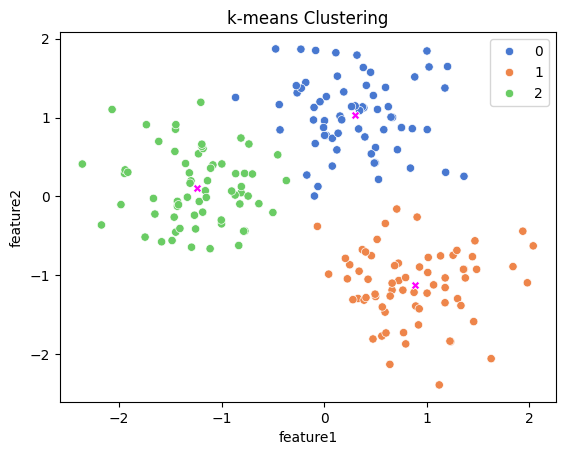

In [16]:
# --------------------
# 군집화 결과 시각화
# --------------------
sns.scatterplot(data=X_scaled, 
                x='feature1', 
                y='feature2', 
                hue='cluster', 
                palette='muted')

# --------------------
# 개별 군집의 중심 좌표
# --------------------
sns.scatterplot(x=km.cluster_centers_[:,0], 
                y=km.cluster_centers_[:,1], 
                color='magenta',
                marker='X')

plt.title('k-means Clustering');

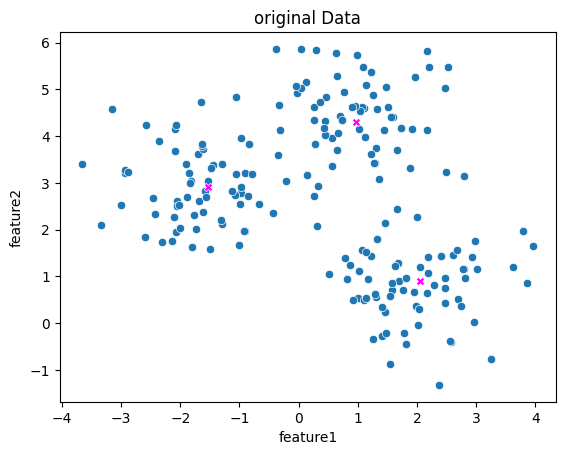

In [17]:
# --------------------
# 데이터 시각화
# --------------------
sns.scatterplot( x='feature1', y='feature2', data=df)

# --------------------
# 개별 군집의 중심 좌표
# --------------------
sns.scatterplot(x=centers_coords[:,0], 
                y=centers_coords[:,1], 
                color='magenta',
                marker='X')

plt.title('original Data');

In [18]:
# --------------------
# 이너셔 
# 클러스터 중심과 클러스터에 속한 샘플 사이의 거리 제곱 합
#  - 클러스터의 샘플이 얼마나 가깝게 있는지를 나타내는 값
# --------------------
km.inertia_

82.28027879566409

🚀 이너셔(Inertia): KMeans 클러스터링의 핵심 평가 지표

"이너셔(Inertia)"는 K-평균(KMeans) 클러스터링 알고리즘에서 군집화가 얼마나 잘 되었는지 평가하는 가장 기본적인 지표

이너셔는 **클러스터 내부의 응집도(Cohesion)**를 나타내는 값

- 이너셔 값이 작다 📉: 데이터 샘플들이 각자의 클러스터 중심에 매우 가깝게 밀집해 있다는 뜻 $\rightarrow$ 군집화가 잘 되었다고 평가

- 이너셔 값이 크다 📈: 데이터 샘플들이 클러스터 중심에서 멀리 퍼져 있다는 뜻 $\rightarrow$ 군집화가 덜 되었다고 평가

**KMeans 알고리즘의 목표**

 이 **이너셔 값(거리 제곱 합)**을 최소화하는 방향으로 클러스터 중심을 찾아 데이터를 분할하는 것  
 모델은 반복적으로 중심을 이동시켜 전체 데이터셋의 이너셔가 가장 낮아지는 지점을 찾으려고 노력

이너셔는 최적의 클러스터 개수($K$)를 결정하는 데 사용

- $K$가 증가할수록 (군집이 많아질수록) 각 군집이 더 작아지고 데이터들이 중심에 더 가까워지므로, 이너셔는 항상 감소

- 하지만 어느 순간부터 이너셔 감소 폭이 급격히 둔화되는 지점(팔꿈치, Elbow)이 나타나는데,   
    이 지점을 최적의 $K$ 값으로 추정하는 엘보우(Elbow) 방법에 이 이너셔 값이 활용

### elbow 방법
- 클러스터 개수를 늘려가면서 이너셔의 변화를 관찰하여 최적의 클러스터 개수를 찾는 방법

In [19]:
inertia = []
for n in range(2,7):
    km = KMeans(n_clusters=n, random_state=42)
    km.fit(X_scaled)
    print(km.inertia_)
    inertia.append(km.inertia_)

316.2117915755855
82.28027879566409
71.68393201031118
64.4946275532062
54.626351918121536


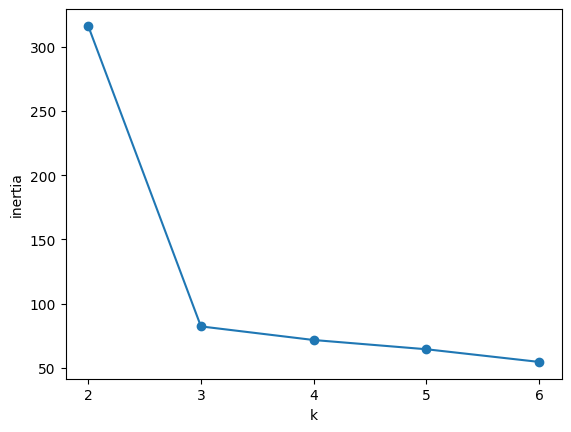

In [20]:
plt.plot(range(2,7), inertia, marker='o')
plt.xticks(range(2,7))
plt.xlabel('k')
plt.ylabel('inertia')
plt.show()

- 팔꿈치(Elbow) 지점은 **$K=3$**이며, 이것이 데이터에 내재된 최적의 군집 개수라고 판단

### 실루엣 분석
- 실루엣 계수 
    - 군집화의 품질을 평가하는 지표
    - 자신의 군집에 얼마나 잘 속해있는지, 다른 군집과는 얼마나 잘 분리되어있는지 측정
    - -1~1 
        - 1에 가까울수록 근처의 군집과 더 멀이 떨어져있다는 의미
        - 0에 가까울수록 가까운 군집과 가까워진다는 의미
        - -값은 다른 군집에 데이터포인트가 할당되었음을 의미
- 개별 실루엣 계수 : `silhouette_samples(features, cluster)`
- 평균 실루엣 계수 : `silhouette_score(features, cluster)`

In [21]:
# ----------------
# 개별 실루엣 계수
# ----------------
from sklearn.metrics import silhouette_samples
X_scaled['silhouette'] = silhouette_samples(features, km.labels_)
X_scaled.head()

,feature1,feature2,cluster,silhouette
0,-1.226105,0.541123,2,0.584777
1,0.155288,1.019338,0,0.104656
2,0.387771,1.124513,0,0.104973
3,-1.085269,0.400190,2,0.607822
4,0.454017,1.574123,0,0.393981


In [22]:
# ------------------
# 다른 군집에 클러스터가 할당된 데이터가 있는지 확인
# ------------------
cond = X_scaled['silhouette'] < 0
X_scaled.loc[cond]

,feature1,feature2,cluster,silhouette
44,1.179545,1.374814,0,-0.003163
51,0.878255,-1.214808,1,-0.017034
69,0.908138,-0.261208,1,-0.000650
113,-0.452421,0.528023,2,-0.027878
144,1.335818,-1.382298,1,-0.067173
158,-0.004977,0.874253,0,-0.003817
168,0.931819,-0.893829,1,-0.067233
193,0.568256,-1.400565,1,-0.063959


In [23]:
# ------------------
# 평균 실루엣 계수
# ------------------
from sklearn.metrics import silhouette_score
silhouette_score(features, km.labels_)

0.39506337674751996

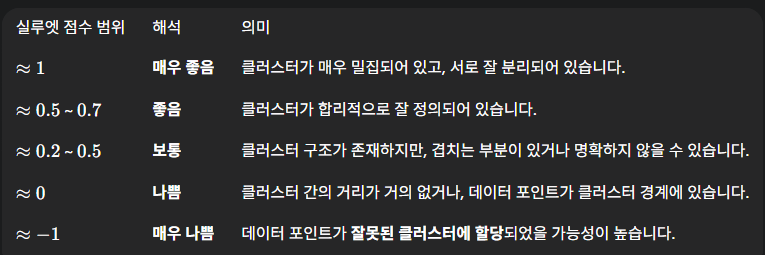

In [24]:
# ------------------
# 최적의 실루엣 찾기
# ------------------
for k in range(2,7):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    score = silhouette_score(features, km.labels_)
    print(f'k={k} ==> {score}')

k=2 ==> 0.32610459314542267
k=3 ==> 0.5763104924404354
k=4 ==> 0.468598807081878
k=5 ==> 0.4716190474404861
k=6 ==> 0.3897548277994947


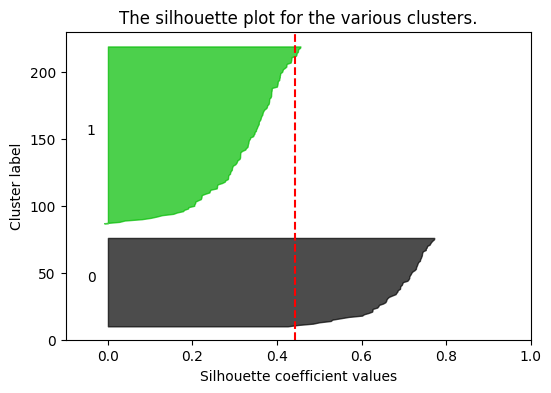

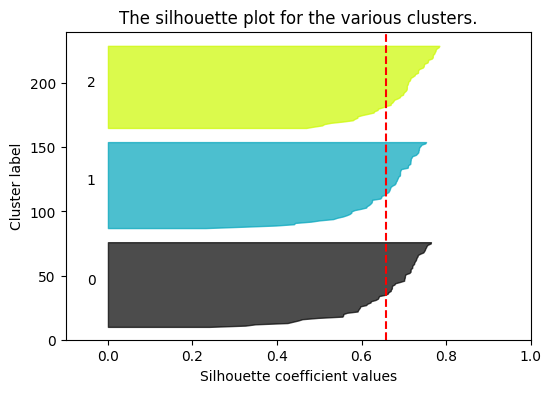

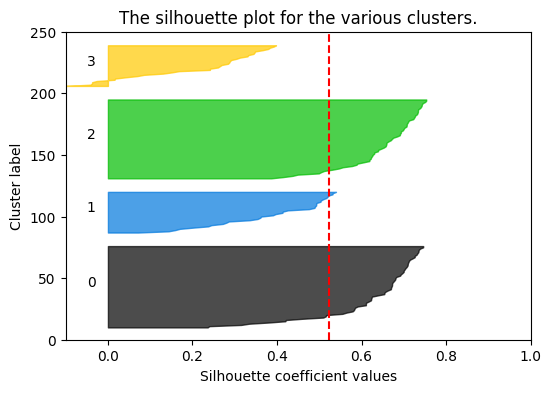

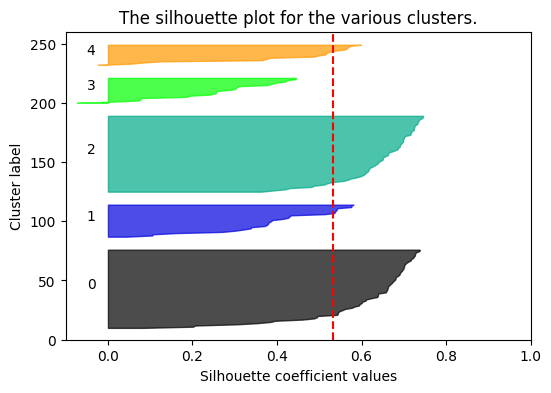

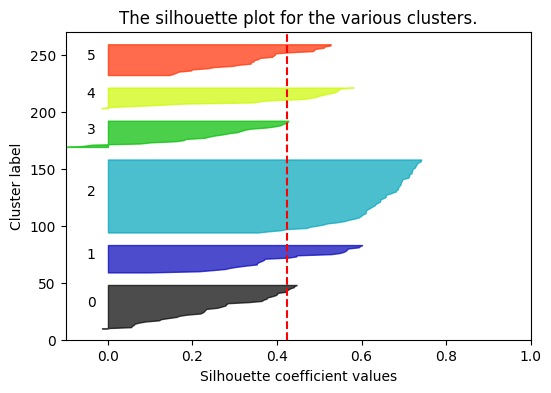

In [25]:
# ------------------
# 실루엣 그래프
#  - 각 군집 내에서 실루엣 계수를 정렬하여 순서대로 그린 그래프
# ------------------
import silhouette_analysis as s

for k in range(2,7):
    s.silhouette_plot(X_scaled, k)

📊 실루엣 그래프 해석 방법 (Silhouette Plot)

1. 개별 실루엣 계수 (각 막대)

    그래프의 왼쪽에서 오른쪽으로 뻗어 있는 막대(Bar) 하나하나가 하나의 데이터 포인트를 나타냄

- 막대의 길이 (좌표): 막대의 길이가 길수록 (1에 가까울수록) 해당 데이터 포인트가 자신의 클러스터 중심에 가깝고,   
    다른 클러스터와 멀리 떨어져 있다는 뜻(즉, 클러스터링이 아주 잘 되었다는 의미)

- 막대의 두께: 해당 클러스터에 속한 데이터 포인트의 개수를 나타냄

2. 평균 실루엣 점수 (빨간 점선)

    그래프 중간에 수직으로 그어진 빨간색 점선은 전체 데이터셋의 평균 실루엣 점수를 나타냄

- 해석: 이 평균 점수보다 오른쪽에 있는 막대가 많을수록 전반적인 클러스터링 품질이 좋다는 의미

<br>

💡 종합 해석 및 최적의 K 찾기

&nbsp;&nbsp;&nbsp; 실루엣 그래프를 통해 최적의 클러스터 개수($K$)를 찾을 때는 다음 조건을 만족하는 $K$를 선택

- **평균 실루엣 점수 (빨간 선)**가 가장 높게 나오는 경우
- 모든 클러스터의 너비(데이터 개수)가 비슷하며
- 모든 클러스터의 막대가 음수 값을 포함하지 않고 평균 선을 넘어서 길게 뻗어 있는 경우

<br>

| 해석 요소 | 좋은 클러스터링 | 나쁜 클러스터링 |
| :---: | :--- | :--- |
| **균형** | 각 클러스터의 막대 두께 (개수)가 **비슷** | 막대 두께가 매우 불균형하여, 특정 군집에만 데이터가 몰려있음|
| **폭** | 모든 막대가 평균 실루엣 선(빨간 점선)보다 **오른쪽**에 길게 뻗어 있음 | 막대가 평균 실루엣 선의 왼쪽에 있거나, 막대 자체가 매우 짧음 |
| **음수 값** | 막대가 **음수 영역 (0 이하)**에 거의 없음 | 막대가 음수 영역까지 길게 뻗어 있다면, <br> 해당 데이터 포인트는 다른 클러스터에 잘못 할당되었음을 의미 |